<a href="https://colab.research.google.com/github/amik123/CNN_Projects/blob/main/Emotion_Detection_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ./kaggle
!cp kaggle.json ./kaggle/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 99% 60.0M/60.3M [00:04<00:00, 19.9MB/s]
100% 60.3M/60.3M [00:04<00:00, 14.3MB/s]


In [ ]:
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers,models,regularizers,optimizers
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.applications import VGG16,ResNet50V2
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization,Activation,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam,Adamax
from keras.utils import plot_model


#Setting up Directory to save Model Data

In [ ]:
# os.makedirs('test_dir',exist_ok=True)

In [ ]:
#Define your Project Name
project_name = 'FER_2013_Emotion_Detection'

#list your models
model_names=['Custom_CNN_From_Scratch',
             'Custom_CNN_With_Augmentation',
             'VGG16_Transfer_Learning',
             'ResNet50V2_Transfer_Learning']

#Base directory(in this case,your google colab workspace)
base_dir = '/content'

#create the project directory
project_dir=os.path.join(base_dir,project_name)
os.makedirs(project_dir,exist_ok=True)

#creating a subdirectory for each model
for model_name in model_names:
  model_dir=os.path.join(project_dir,model_name)
  os.makedirs(model_dir,exist_ok=True)

print(f'porject directory structure created at:{project_dir}')

porject directory structure created at:/content/FER_2013_Emotion_Detection


#Data cleaning

In [ ]:
image_exts=['jpeg','jpg','png']
data_dir='/content/train'
for root,dirs,files in os.walk(data_dir):

  for file in files:
    file_path=os.path.join(root,file)

    try:
      file_type=imghdr.what(file_path)

      if file_type not in image_exts:
        print(f'Image not in ext list{file_path}')
        os.remove(file_path)

      else:
        img=cv2.imread(file_path)

    except Exception as e:
      print(f'Issue with image {file_path},Error:{e}')
      os.remove(file_path)

#Data Analysis

In [ ]:
#Define a function to count the number of files(assumed to be images for this context) for each subdirectory in a given directory
def count_files_in_subdirs(directory,set_name):
  counts=dict()
  for item in os.listdir(directory):
    item_path=os.path.join(directory,item)

    if os.path.isdir(item_path):
      counts[item]=len(os.listdir(item_path))

  df=pd.DataFrame(counts,index=[set_name])
  return df



In [ ]:
#Paths to the training and testing directories.
train_dir='/content/train'
test_dir='/content/test'

train_count=count_files_in_subdirs(train_dir,'train')
test_count=count_files_in_subdirs(test_dir,'test')

print(train_count)
print(test_count)

In [ ]:
train_count.transpose().plot(kind='bar')

In [ ]:
test_count.transpose().plot(kind='bar')

#Plotting one image from each emotion.

In [ ]:
emotions=os.listdir(train_dir)
plt.figure(figsize=(12,12))
for i,emotion in enumerate(emotions):
  path=os.path.join(train_dir,emotion)
  img_name=os.listdir(path)[42]
  img=cv2.imread(os.path.join(path,img_name))
  plt.subplot(3,4,i+1)
  plt.imshow(img)
  plt.title(emotion)
  plt.axis('off')

#Plotting random Images from given directory

In [ ]:
def plot_random_images(directory,class_name):
  plt.figure(figsize=(12,12))
  for i in range(9):
    path=os.path.join(directory,random.choice(os.listdir(directory)))
    img=cv2.imread(path)
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

In [ ]:
happy_dir='/content/train/happy'
plot_random_images(happy_dir,'happy')

#Checking shapes and channels

In [ ]:
dir_path='/content/train/angry/'
image=random.choice(os.listdir(dir_path))
image_path=os.path.join(dir_path,image)
img=cv2.imread(image_path)
if img is not None:
  print('shape:',img.shape)
else:
  print('Image not found')

#Model1: Custom CNN from Scratch

##Initializing the ImageGenerators

In [ ]:
train_data_dir='/content/train'
test_data_dir='/content/test'

In [ ]:
img_width,img_height=48,48
batch_size=64
epochs=10
num_classes=7

In [ ]:
#Rescale the pixel values(0-255) to the [0,1] interval
data_generator=ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

#Automatically retrieve images and their classes for train and validation sets
train_generator=data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator=data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator=data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical')



In [ ]:
# for batch in train_generator:
#   print(batch[0].shape)

In [ ]:
#Accessing class labels for the training data
train_class_labels=train_generator.class_indices
print("Training class labels:",train_class_labels)

#Accessing class labels for the validation data
validation_class_labels=validation_generator.class_indices
print("Validation class labels:",validation_class_labels)

#Accesing class labels for the test data
test_class_labels=test_generator.class_indices
print("Test class labels:",test_class_labels)

In [ ]:
#Initialising the cnn
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3),kernel_initializer='glorot_uniform',padding='same',input_shape=(img_width,img_height,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(128,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(0.01)))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.summary()

In [ ]:
plot_model(model,to_file='/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Architecture.png',
           show_shapes=True,show_layer_names=True)

In [ ]:
#Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Understanding Callbacks


In [ ]:
#File path for the model checkpoints
cnn_path='/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch'
name='Custom_CNN_From_Scratch'
chk_path=os.path.join(cnn_path,name)
chk_path

In [ ]:
#callback to save the model checkpoints
checkpoint=ModelCheckpoint(filepath=chk_path,save_best_only=True,
                           verbose=1,mode='min',monitor='val_loss')

In [ ]:
#callback for early stopping
early_stop=EarlyStopping(monitor='val_loss',patience=3,
                         verbose=1,restore_best_weights=True,min_delta=0)

In [ ]:
#callback to reduce learning rate
reduce_lr=ReduceLROnPlateau(monitor='val_loss',
                            factor=0.2,patience=6,
                            verbose=1,min_delta=0.0001)

In [ ]:
#callback to log training data to a csv file
csv_logger=CSVLogger(os.path.join(cnn_path,'training.log')) #logs the training data (like loss and accuracy metrics for each epoch) to a CSV file named "training.log"

In [ ]:
callbacks=[checkpoint,early_stop,reduce_lr,csv_logger]

#Calculating steps per epoch

In [ ]:
train_steps_per_epoch=train_generator.samples//train_generator.batch_size +1
validation_steps_per_epoch=validation_generator.samples//validation_generator.batch_size +1
test_steps_per_epoch=test_generator.samples//test_generator.batch_size+1

In [ ]:
train_steps_per_epoch

#Model Training

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps_per_epoch,
    callbacks=callbacks)

In [ ]:
# # Print the shape of a batch from the training generator
# for batch in train_generator:
#     print("Input batch shape:", batch[1].shape)  # Assuming batch[0] contains the input data
#     break

# # Print the expected input shape of the model
# print("Model input shape:", model.input_shape)

#Plotting Performance Metrics

In [ ]:
def plot_training_history(history):
  acc=history.history['accuracy']
  val_acc=history.history['val_accuracy']
  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range=range(len(acc))
  plt.figure(figsize=(20,5))

  #plot training and validation accuracy
  plt.subplot(1,2,1)
  plt.plot(epochs_range,acc,label='Training Accuracy')
  plt.plot(epochs_range,val_acc,label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and validation accuracy')

  #plot training and validation loss
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and validation loss')
  plt.show()

In [ ]:
plot_training_history(history)

#Model Evaluation

In [ ]:
train_loss,train_acc=model.evaluate(train_generator)
test_loss,test_acc=model.evaluate(test_generator)

#Plot Confusing Matrix

In [ ]:
true_classes=test_generator.classes
predicted_classes=np.argmax(model.predict(test_generator,steps=np.ceil(test_generator.samples/test_generator.batch_size)),axis=1)
class_labels=list(test_generator.class_indices.keys())

#Generate the confusion matrix
cm=confusion_matrix(true_classes,predicted_classes)

#Plotting with Seaborn
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d',xticklabels=class_labels,yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [ ]:
#Printing the classification report
report=classification_report(true_classes,predicted_classes,target_names=class_labels)
print('Classification Report:\n',report)

#Making Predictions

In [ ]:
#Emotion classes for the dataset
Emotion_Classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']
batch_size=test_generator.batch_size #The test_generator is an instance that provides batches of test images and labels.

#Selecting a random batch from the test generator
Random_batch=np.random.randint(0,len(test_generator)-1)

#Selecting random image indices from the batch
Random_image_indices=np.random.randint(0,batch_size,10) #10 is the number of integers to be generated

#setting up the plot
fig,axes=plt.subplots(nrows=2,ncols=5,figsize=(10,5),subplot_kw={'xticks':[],'yticks':[]})

#plotting the images
for i,ax in enumerate(axes.flat):
  Random_Img=test_generator[Random_batch][0][Random_image_indices[i]]
  Random_Img_Label=np.argmax(test_generator[Random_batch][1][Random_image_indices[i]],axis=0)

  # Making a prediction using the model
  Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

  # Displaying the image
  ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
  # Setting the title with true and predicted labels, colored based on correctness
  color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
  ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

Model2:Image Augmentation

In [ ]:
#Define paths to the train and test directories
train_data_dir='/content/train'
test_data_dir='/content/test'

#Set some parameters
img_width,img_height=48,48
batch_size=64
epochs=10
num_classes=7

#Initializing the ImageDataGenerator with data augmentation options for the training set
data_generator=ImageDataGenerator(rescale=1./255, #Rescale the pixel values from [0,255] to [0,1]
                                  rotation_range=40, #Degree range for random rotations
                                  width_shift_range=0.2, # Range (as a fraction of total width) for random horizontal shifts
                                  height_shift_range=0.2, # Range (as a fraction of total height) for random vertical shifts
                                  shear_range=0.2, # Shear intensity (shear angle in counter-clockwise direction in degrees)
                                  zoom_range=0.2, # Range for random zoom
                                  horizontal_flip=True, # Randomly flip images horizontally
                                  fill_mode='nearest', # Method for filling in newly created pixels after transformations
                                  validation_split=0.2) # Fraction of images reserved for validation

test_data_generator=ImageDataGenerator(rescale=1./255)

#Automatically retrieve images and their classes for train and validation sets
train_generator=data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator=data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator=test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical')

In [ ]:
# Path to your specific image
image_path = '/content/train/angry/Training_10118481.jpg'

# Load and convert the image to an array
img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))  # Adjust color_mode if necessary
img_array = img_to_array(img)  # Converts the image to a numpy array
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to (1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch

    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

#Slight modification of CNN model as above

In [ ]:
# Assuming img_width, img_height, and classes are defined. For example:
img_width, img_height = 48, 48
classes = 7

#Initialising the CNN
model = tf.keras.models.Sequential()

# Adding convolutional layers with activations on separate lines
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(tf.keras.layers.Activation('softmax'))

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

In [ ]:
plot_training_history(history) #Function is written above already

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

#Model3:Transfer Learning VGGNET
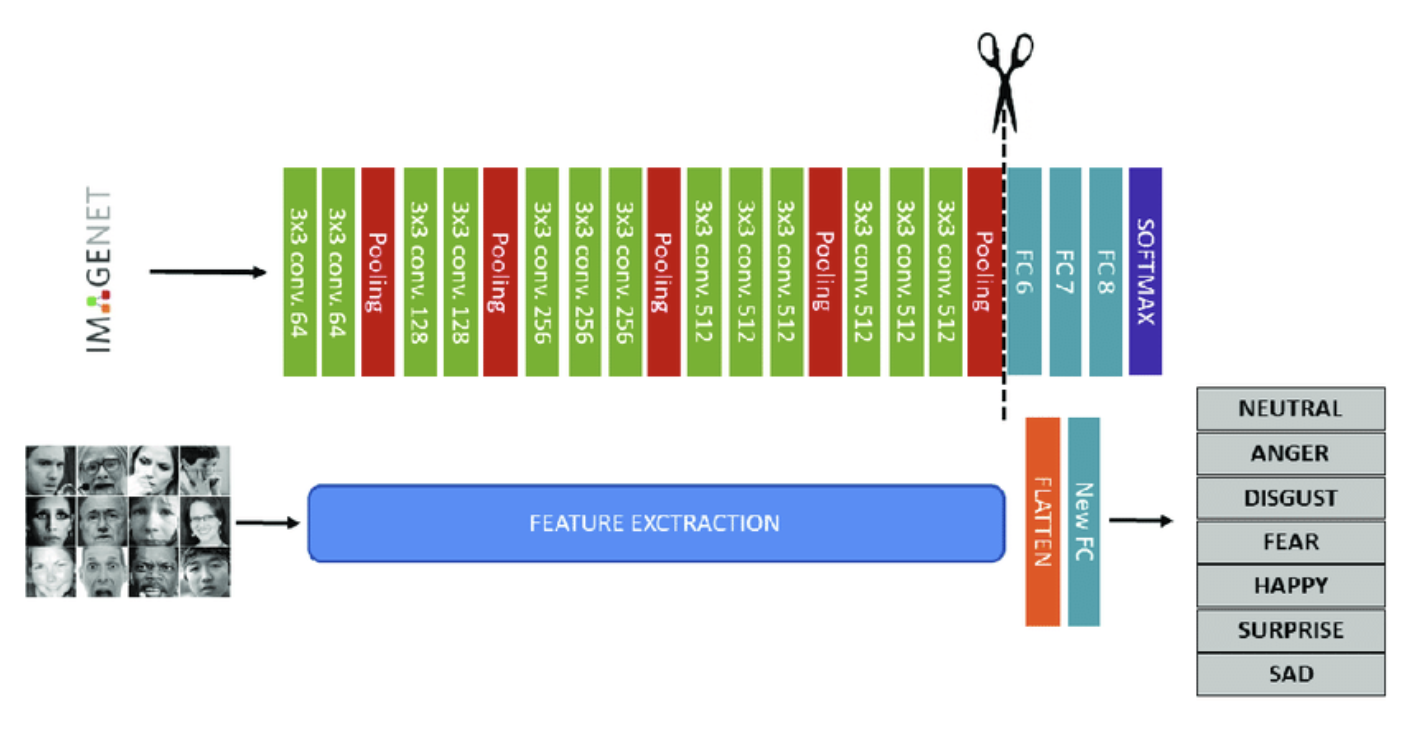

In [ ]:
train_data_dir='/content/train'
test_data_dir='/content/test'
#set some parameters
img_width,img_height=224,224
batch_size=64
epochs=10
num_classes=7

#Rescale the pixel values(0-255) to the [0,1] interval
train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

#Automatically retrieves images and their classes for train and test dataset
train_generator=train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)
test_generator=test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',)



Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
vgg=VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
for layer in vgg.layers[:-3]:
  layer.trainable=False
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
print(vgg.output.name)
print(vgg.input)

block5_pool/MaxPool:0
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [ ]:
#Flattening the layer and adding custom Dense layers
x=Flatten()(vgg.output)
x=Dense(1024,activation='relu',kernel_initializer='he_uniform')(x)
x=Dropout(0.2)(x)
x=Dense(512,activation='relu',kernel_initializer='he_uniform')(x)
x=Dropout(0.2)(x)
output=Dense(num_classes,activation='softmax')(x)

#Creating the model
model=Model(inputs=vgg.input,outputs=output)

#Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

#Model summary to see all the layers
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#file path for the model checkpoint
cnn_path='/content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning'
name='VGG16_Transfer_Learning.keras'
chk_path=os.path.join(cnn_path,name)

#callback to save the model checkpoint
checkpoint=ModelCheckpoint(filepath=chk_path,
                           save_best_only=True,
                           verbose=1,
                           mode='min',#mode='min' means the checkpoint will be saved when the monitored quantity (in this case, val_loss) reaches a new minimum.
                           monitor='val_loss')

#Callback for early stopping
earlystop=EarlyStopping(monitor='val_loss',
                        min_delta=0,
                        patience=3,
                        verbose=1,
                        restore_best_weights=True
                        )

#Callback to reduce learning rate
reduce_lr=ReduceLROnPlateau(monitor='val_loss',
                            factor=0.2,
                            patience=6,
                            verbose=1,
                            min_delta=0.0001)

#Callback to log training data to a CSV file
csv_logger=CSVLogger(os.path.join(cnn_path,'training.log'))

#Aggregating all callbacks into a list
callbacks=[checkpoint,earlystop,reduce_lr,csv_logger]

train_steps_per_epoch=train_generator.samples//train_generator.batch_size
test_steps_per_epoch=test_generator.samples//test_generator.batch_size

In [ ]:
history=model.fit(train_generator,
                  steps_per_epoch=train_steps_per_epoch,
                  validation_data=test_generator,
                  validation_steps=test_steps_per_epoch,
                  epochs=5,
                  callbacks=callbacks)

Epoch 1/5
448/448 [==============================] - ETA: 0s - loss: 1.7172 - accuracy: 0.3129
Epoch 1: val_loss improved from inf to 1.58153, saving model to /content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
448/448 [==============================] - 186s 377ms/step - loss: 1.7172 - accuracy: 0.3129 - val_loss: 1.5815 - val_accuracy: 0.3771 - lr: 0.0010
Epoch 2/5
448/448 [==============================] - ETA: 0s - loss: 1.5470 - accuracy: 0.3875
Epoch 2: val_loss improved from 1.58153 to 1.49886, saving model to /content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
448/448 [==============================] - 168s 376ms/step - loss: 1.5470 - accuracy: 0.3875 - val_loss: 1.4989 - val_accuracy: 0.4129 - lr: 0.0010
Epoch 3/5
448/448 [==============================] - ETA: 0s - loss: 1.4420 - accuracy: 0.4431
Epoch 3: val_loss improved from 1.49886 to 1.39065, saving model to /content/FER_2013_Emotion_Detection/VGG

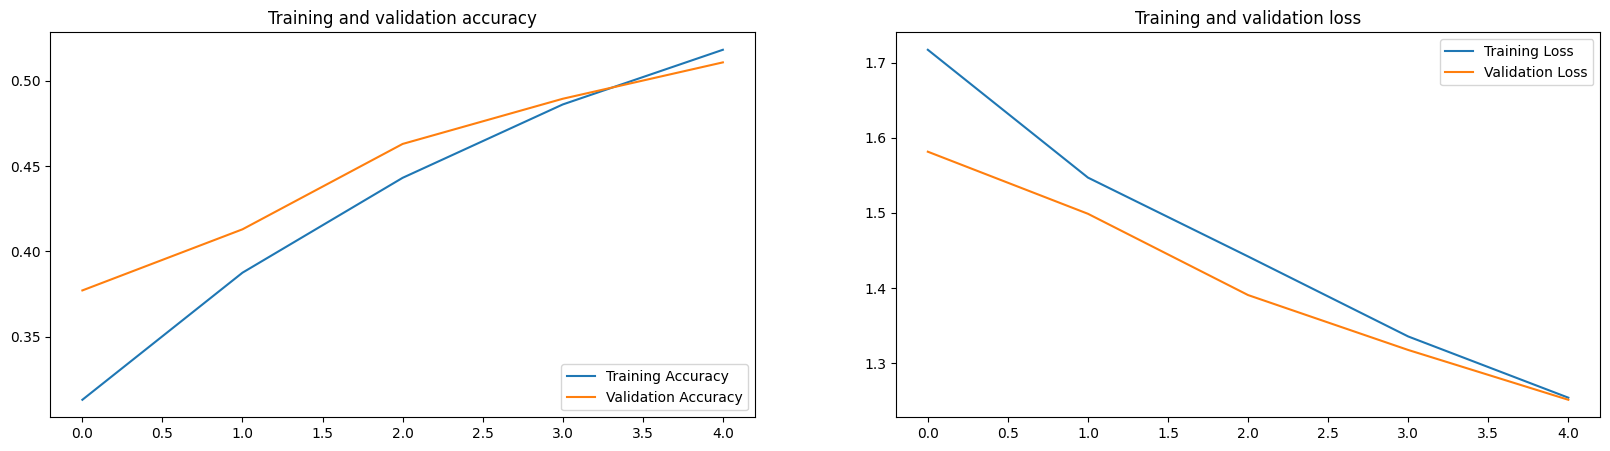

In [ ]:
plot_training_history(history)

In [ ]:
train_loss,train_acc=model.evaluate(train_generator)
test_loss,test_acc=model.evaluate(test_generator)
print('final train accuracy={:.2f},validation accuracy={:.2f}'.format(train_acc*100,test_acc*100))

113/113 [==============================] - 32s 286ms/step - loss: 1.2517 - accuracy: 0.5109
final train accuracy=54.49,validation accuracy=51.09


113/113 [==============================] - 32s 280ms/step


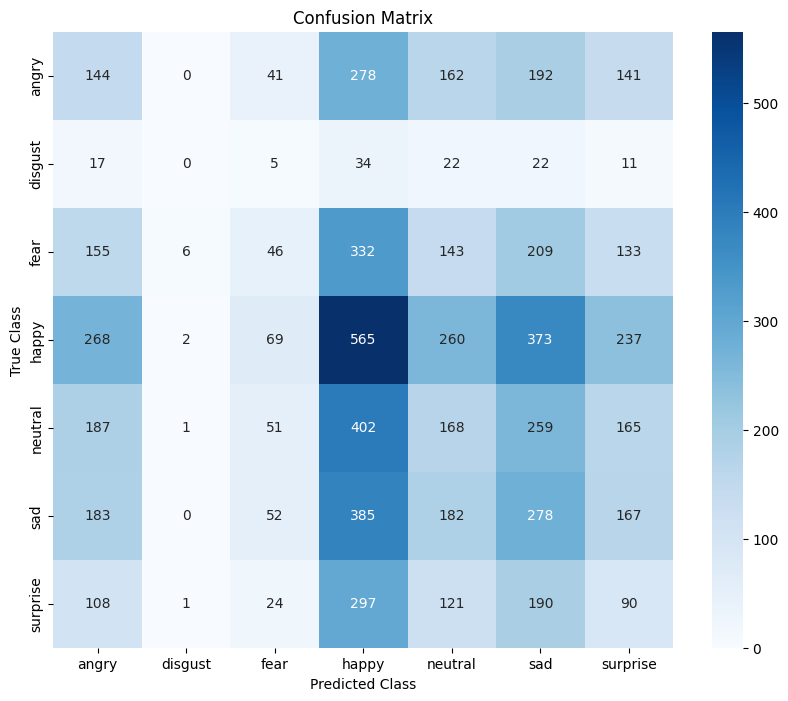

In [ ]:
true_classes=test_generator.classes
predicted_classes=np.argmax(model.predict(test_generator),axis=1)
class_labels=list(test_generator.class_indices.keys())

#Generate the confusion matrix
cm=confusion_matrix(true_classes,predicted_classes)

#plotting with seaborn
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=class_labels,yticklabels=class_labels)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Printing the classification report
report=classification_report(true_classes,
                             predicted_classes,
                             target_names=class_labels,
                             zero_division=0)
print('classification report:\n',report)

classification report:
               precision    recall  f1-score   support

       angry       0.14      0.15      0.14       958
     disgust       0.00      0.00      0.00       111
        fear       0.16      0.04      0.07      1024
       happy       0.25      0.32      0.28      1774
     neutral       0.16      0.14      0.15      1233
         sad       0.18      0.22      0.20      1247
    surprise       0.10      0.11      0.10       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.18      0.17      7178



#Model4:Transfer Learning-ResNet50

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'

# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(rescale=1/255,                # Rescale pixel values to [0, 1]
                                  rotation_range=10,            # Randomly rotate images in the range (degrees, 0 to 180)
                                  width_shift_range=0.1,        # Randomly horizontally shift images
                                  height_shift_range=0.1,       # Randomly vertically shift images
                                               # Apply shearing transformations
                                  zoom_range=0.1,               # Randomly zoom image
                                  horizontal_flip=True,         # Randomly flip images horizontally
                                  fill_mode='nearest'           # Strategy used for filling in newly created pixels
                                )

# Rescaling for validation/test data (without further data augmentation)
test_datagen = ImageDataGenerator(
                                  rescale=1/255.                 # Rescale pixel values to [0, 1]
                              )

# Creating data generators for training
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,
                                                    target_size=(224, 224),       # Resize images to 224x224 for model input
                                                    color_mode='rgb',             # Images will be converted to RGB
                                                    class_mode='categorical',     # For multi-class classification
                                                    batch_size=64                 # Size of the batches of data
                                                )

# Creating data generators for testing/validation
test_generator = test_datagen.flow_from_directory(
                                                  test_dir,
                                                  target_size=(224, 224),       # Resize images to 224x224 for model input
                                                  color_mode='rgb',             # Images will be converted to RGB
                                                  class_mode='categorical',     # For multi-class classification
                                                  batch_size=64                 # Size of the batches of data
                                              )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


#Introducing Class weights for imbalanced data

In [ ]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

In [ ]:
#Freezing all layers except last 60
for layer in ResNet50V2.layers[:-50]:
  layer.trainable=False

In [ ]:
input_shape = (224, 224, 3)


model = Sequential([
                    ResNet50V2,
                    BatchNormalization(),
                    GlobalAveragePooling2D(),
                    Dense(512, activation='relu'),
                    Dropout(0.1),
                    Dense(256, activation='relu'),
                    Dropout(0.1),
                    Dense(128, activation='relu'),
                    Dropout(0.1),
                    Dense(7, activation='softmax')
                  ])

optimizer = Adamax(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 batch_normalization_24 (Ba  (None, 7, 7, 2048)        8192      
 tchNormalization)                                               
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_30 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_28 (Dropout)        (None, 512)               0         
                                                                 
 dense_31 (Dense)            (None, 256)             

In [ ]:
len(base_model.layers)

190

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=6,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
#load the model
import keras
amik=keras.saving.load_model('/content/drive/MyDrive/Emotion detection project/resneton_process')

In [ ]:
train_history = amik.fit(
                          train_generator,
                          steps_per_epoch=200,
                          epochs=50,
                          validation_data=test_generator,
                          validation_steps=100,
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                        )

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.6821 - accuracy: 0.7243
Epoch 1: val_loss improved from inf to 1.04441, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
200/200 [==============================] - 219s 991ms/step - loss: 0.6821 - accuracy: 0.7243 - val_loss: 1.0444 - val_accuracy: 0.6541
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.6321 - accuracy: 0.7486
Epoch 2: val_loss did not improve from 1.04441
200/200 [==============================] - 199s 994ms/step - loss: 0.6321 - accuracy: 0.7486 - val_loss: 1.0525 - val_accuracy: 0.6589
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.6333 - accuracy: 0.7452
Epoch 3: val_loss improved from 1.04441 to 1.00954, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
200/200 [==============================] - 197s 988ms/step - loss: 0.63

In [ ]:
amik.save("/content/drive/MyDrive/Emotion detection project/fin_resneton_process") #this will save the model in /content of colab.

In [ ]:
#we can direct evaluate from the loaded model
# train_loss, train_accu = amik.evaluate(train_generator)
# test_loss, test_accu = amik.evaluate(test_generator)

In [ ]:
#I can as well continue training from last epochs
# train_history = amik.fit(
#                           train_generator,
#                           steps_per_epoch=train_steps_per_epoch,
#                           epochs=5,
#                           validation_data=test_generator,
#                           validation_steps=test_steps_epoch,
#                           class_weight=class_weights_dict,
#                           callbacks = callbacks
#                          )

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

#AUC ROC plot for each class

In [ ]:
true_labels=test_generator.classes
preds=model.predict(test_generator,steps=len(test_generator))
pred_labels=np.argmax(preds,axis=1)
